# Plot evaluations of sounding data from 1997-2016, 12Z

https://weather.uwyo.edu/upperair/sounding.html

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 12})
import xarray as xr
import pandas as pd

from datetime import datetime
from datetime import timedelta

# meteorology - specific
from metpy.calc import relative_humidity_from_dewpoint
from metpy.units import units
from siphon.simplewebservice.wyoming import WyomingUpperAir

import sys
sys.path.append('./scripts/')

from LIB_dates import generate_date_list
from LIB_request_WUA_sounding import check_for_WUA_soundings
from LIB_sounding_analysis import interpolate_soundings
from LIB_sounding_date_checks import grab_sounding_dates

### Plot relative humidity distributions (density histograms) as a function of height for each season from 12Z soundings 1997 - 2016

 >>> save as ./figures/RH_seasonalrange_1997-2016.png


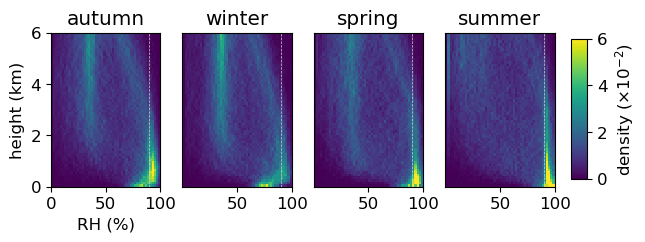

In [2]:
# seasons to plot
# relative humidity threshold for clouds
#==================================================
seasons = ['autumn', 'winter', 'spring', 'summer']
rh_thresh = 90
#==================================================

# bin width, min edge, and max edge
# for RH distribution bins
#=====================================
width = 2
bin_min = 0
bin_max = 100
#=====================================
bin_edges = np.arange(bin_min,bin_max+width,width)
bin_centers = np.arange(bin_min+width/2,bin_max,width)


fig, axs = plt.subplots(1,len(seasons), figsize=(6.5,2))

for ss, season in enumerate(seasons):

    # open seasonal data
    ds = xr.open_dataset(f'./figures/{season}_1997-2016.nc')

    # create density histogram at each height (integral across RH bins == 1)
    # across all non-nan values
    H = ds.h.values
    HIST = np.array([])
    for hh, HH in enumerate(H):
        RH_vals = ds.RH.sel(h=HH).values
        the_hist = np.histogram(RH_vals[np.isnan(RH_vals) == False], bins = bin_edges, density=True);
        HIST = np.append(HIST, the_hist[0])

    # reshap histograms into grids
    HIST = np.reshape(HIST, (len(H),len(bin_centers)))
    rh, height = np.meshgrid(bin_centers, H)
    
    # plot distribution
    dens = axs[ss].pcolormesh(rh, height, HIST*100, vmin=0, vmax=6)
    
    # plot labels
    axs[ss].set_title(f'{season}')
    if ss == 0:
        axs[ss].set_ylabel('height (km)')
        axs[ss].set_xlabel('RH (%)')
    else:
        axs[ss].set_yticks([])
        axs[ss].set_xticks([50,100])
        
        
    axs[ss].vlines(rh_thresh, 0, 6, colors='lightgray', linestyles='dashed', linewidths=0.5)
    
# colorbar
cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
fig.colorbar(dens, label='density ($\\times 10^{-2}$)', cax=cbar_ax)


# save
savename = f'./figures/RH_seasonalrange_{ds.year[0].values}-{ds.year[-1].values}.png'
print(f' >>> save as {savename}')
fig.savefig(savename, transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)



### Plot temperature distributions (density histograms) as a function of height for each season from 12Z soundings 1997 - 2016

 >>> save as ./figures/T_seasonalrange_1997-2016.png


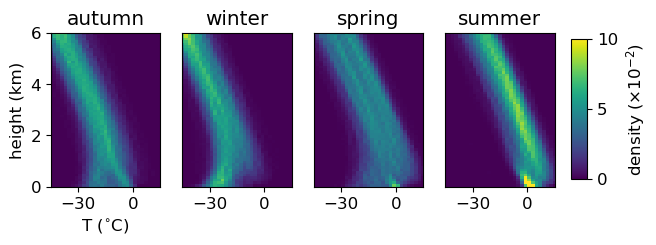

In [3]:

# seasons to plot
#==================================================
seasons = ['autumn', 'winter', 'spring', 'summer']
#==================================================

# specify bin width, min edge, and max edge
# for T distribution bins
#=====================================
width = 2
bin_min = -46
bin_max = 18
#=====================================
bin_edges = np.arange(bin_min,bin_max+width,width)
bin_centers = np.arange(bin_min+width/2,bin_max,width)



fig, axs = plt.subplots(1,len(seasons), figsize=(6.5,2))

for ss, season in enumerate(seasons):

    # open seasonal data
    ds = xr.open_dataset(f'./figures/{season}_1997-2016.nc')

    # create density histogram at each height (integral across RH bins == 1)
    # across all non-nan values
    H = ds.h.values
    HIST = np.array([])

    for hh, HH in enumerate(H):
        T_vals = ds.T.sel(h=HH).values
        the_hist = np.histogram(T_vals[np.isnan(T_vals) == False], bins = bin_edges, density=True);
        HIST = np.append(HIST, the_hist[0])

    # reshap histograms into grids
    HIST = np.reshape(HIST, (len(H),len(bin_centers)))
    rh, height = np.meshgrid(bin_centers, H)
    
    # plot density
    dens = axs[ss].pcolormesh(rh, height, HIST*100, vmin=0, vmax=10)
    
    # plot labels
    axs[ss].set_title(f'{season}')
    axs[ss].set_xlim(-45,15)
    axs[ss].set_xticks([-30,-0])
    if ss == 0:
        axs[ss].set_ylabel('height (km)')
        axs[ss].set_xlabel('T ($^{\circ}$C)')
    else:
        axs[ss].set_yticks([])
        
# colorbar
cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
fig.colorbar(dens, label='density ($\\times 10^{-2}$)', cax=cbar_ax, ticks=[0,5,10])

# save
savename = f'./figures/T_seasonalrange_{ds.year[0].values}-{ds.year[-1].values}.png'
print(f' >>> save as {savename}')
fig.savefig(savename, transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)


### Plot frequency of RH threshold passed seasonall as a function of height

Various sources suggest temperature ranges where we might expect liquid vs supercooled water vs mixed ice/supercooled vs ice only only to exist in clouds:

- liquid: 0 C < T

- supercooled liquid: -15 C < T < 0 C

- mixed ice/supercooled: -40 C < T < -15 C

- ice: T < -40 C


Sources:

- https://www.skybrary.aero/articles/supercooled-water-droplets#:~:text=At%20temperatures%20between%200%C2%B0,crystals%20and%20supercooled%20water%20droplets.
- https://earthobservatory.nasa.gov/images/84916/supercool-clouds
- https://www.weather.gov/source/zhu/ZHU_Training_Page/clouds/cloud_development/clouds.htm

1997-2016, 12Z
T when RH >= 90
 >>> save as ./figures/T_RH90_seasonalrange_1997-2016.png


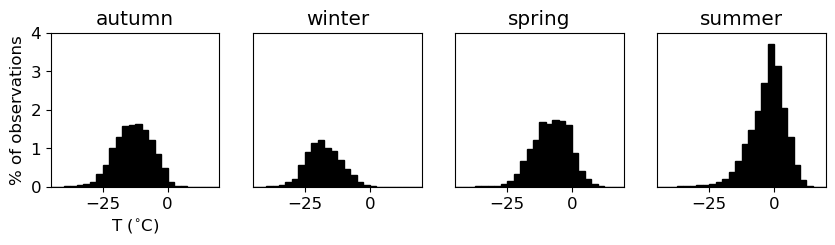

In [4]:
#==================================================
seasons = ['autumn', 'winter', 'spring', 'summer']
colors = ['blue', 'dodgerblue', 'indianred', 'darkorange']
rh_thresh = 90
hours = [12]
show_cloud_type = False
#============================================================

fig, axs = plt.subplots(1,len(seasons), figsize=(10,2))

width = 2.5
bin_min = -45
bin_max = 20
bin_edges = np.arange(bin_min,bin_max+width,width)
bin_centers = np.arange(bin_min+width/2,bin_max,width)

for ss, season in enumerate(seasons):

    # open seasonal data
    ds = xr.open_dataset(f'./figures/{season}_1997-2016.nc')

    # find total counts of 'clouds' in different temperature bins
    hist_out = np.histogram(ds.T.values[ds.RH >= rh_thresh], bins=bin_edges)
    
    # plot cloud occurence counts per total observations (times 100 to give % of total obs)
    # find total obs #
    total_obs = (np.isnan(ds.RH)==False).sum(dim='doy').sum(dim='year').sum(dim='h').data
    
    if show_cloud_type == True:
        axs[ss].bar(bin_centers[(bin_centers<=-15)], 100*hist_out[0][(bin_centers<=-15)]/107770, width = width, facecolor=[0.9,0.9,0.9], edgecolor='k', alpha=1, label='mix')
        axs[ss].bar(bin_centers[(bin_centers<0)&(bin_centers>-15)], 100*hist_out[0][(bin_centers<0)&(bin_centers>-15)]/107770, width = width, facecolor=[255/255,165/255, 100/255], edgecolor='k', alpha=1, label='supercool')
        axs[ss].bar(bin_centers[bin_centers>=0], 100*hist_out[0][bin_centers>=0]/107770, width = width, facecolor=[50/255,150/255,255/255], edgecolor='k', alpha=1, label='liquid')
        if ss == 0:
            axs[ss].legend()
    else:
        axs[ss].bar(bin_centers[(bin_centers<=-15)], 100*hist_out[0][(bin_centers<=-15)]/107770, width = width, facecolor='k', edgecolor='k', alpha=1, label='mix')
        axs[ss].bar(bin_centers[(bin_centers<0)&(bin_centers>-15)], 100*hist_out[0][(bin_centers<0)&(bin_centers>-15)]/107770, width = width, facecolor='k', edgecolor='k', alpha=1, label='supercool')
        axs[ss].bar(bin_centers[bin_centers>=0], 100*hist_out[0][bin_centers>=0]/107770, width = width, facecolor='k', edgecolor='k', alpha=1, label='liquid')
    
    # plot labels
    axs[ss].set_title(f'{season}')
    axs[ss].set_xlim(-45,20)
    axs[ss].set_ylim(0,4)
    if ss == 0:
        axs[ss].set_ylabel('% of observations')
        axs[ss].set_xlabel('T ($^{\circ}$C)')
    if ss > 0:
        axs[ss].set_yticks([])
    
        
print(f'{ds.year[0].values}-{ds.year[-1].values}, {hours[0]}Z\nT when RH >= {rh_thresh}')

# save
savename = f'./figures/T_RH{rh_thresh}_seasonalrange_{ds.year[0].values}-{ds.year[-1].values}.png'
print(f' >>> save as {savename}')
fig.savefig(savename, transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)



### Calculate distribution of heights that different cloud types (temperature-defined) occur at in each season

In [5]:

#==============
rh_thresh = 90
#==============


# create dictionary to store all
cloud_heigh_type = {}
for season in seasons:
    cloud_heigh_type[season] = {}
    
# run through all seasons
for ss, season in enumerate(seasons):

    liq_heights = np.array([])
    sco_heights = np.array([])
    mix_heights = np.array([])

    # open seasonal data
    ds = xr.open_dataset(f'./figures/{season}_1997-2016.nc')
    
    # find total number of days with observations
    total_obs = (np.isnan(ds.RH)==False).sum(dim='doy').sum(dim='year').sum(dim='h').data
    cloud_heigh_type[season]['total_obs'] = total_obs
    
    # run through day by day and collect heights
    # where different cloud types might exist
    for year in ds.year:
        for doy in ds.doy:

            # grab heights with specific constraints
            ds_spec = ds.sel(year=year, doy=doy)

            # liquid clouds
            liq_height = ds_spec.h.values[(ds_spec.T>=0)&(ds_spec.RH>=rh_thresh)]
            # supercooled
            sco_height = ds_spec.h.values[(ds_spec.T>=-15)&(ds_spec.T<0)&(ds_spec.RH>=rh_thresh)]
            # mixed (or ice only, below -40 C but there were only 2 occurences of this)
            mix_height = ds_spec.h.values[(ds_spec.T<-15)&(ds_spec.RH>=rh_thresh)]

            liq_heights = np.append(liq_heights, liq_height)
            sco_heights = np.append(sco_heights, sco_height)
            mix_heights = np.append(mix_heights, mix_height)
            
    # save to dictionary
    cloud_heigh_type[season]['liquid'] = liq_heights
    cloud_heigh_type[season]['supercool'] = sco_heights
    cloud_heigh_type[season]['mix'] = mix_heights
    
    

### Plot distributions

In [ ]:

cloud_type = ['liquid', 'supercool', 'mix']
colors = [[50/255,150/255,255/255], [255/255,165/255, 100/255], [0.7,0.7,0.7]]

width = 0.1
bin_min = 0
bin_max = 6
bin_edges = np.arange(bin_min,bin_max+width,width)
bin_centers = np.arange(bin_min+width/2,bin_max,width)


fig, axs = plt.subplots(len(cloud_type),len(seasons), figsize=(6,8))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for tt, cloud in enumerate(cloud_type):
    for ss, season in enumerate(seasons):

        # plot histograms per season per cloud type
        h_out = np.histogram(cloud_heigh_type[season][cloud], bins=bin_edges, density = True)
        axs[tt][ss].barh(bin_centers, h_out[0], height=width, facecolor =colors[tt], alpha=0.8, zorder=1, label=cloud)
        axs[tt][ss].step(h_out[0], bin_edges[:-1], c=colors[tt], alpha=1, where ='pre', zorder=1)
        
        
        # labels
        if tt == 0:
            axs[tt][ss].set_title(f'{season}')
        if ss == 0:
            if tt == 2:
                axs[tt][ss].set_ylabel(f'height (km)')
                axs[tt][ss].set_xlabel(f'density')
        else:
            axs[tt][ss].set_yticks([])
        if tt == 2:
            axs[tt][ss].set_xticks([0,1])
        else:
            axs[tt][ss].set_xticks([])
        if ss == 3:
            axs[tt][ss].text(2,3, cloud, c=colors[tt], weight='bold',
                             horizontalalignment='left', verticalalignment='center')
        axs[tt][ss].set_xlim(-0.1,1.8)
        axs[tt][ss].set_ylim(-0.1,6.1)
        
        # horizontal reference lines
        for h_ref in [1,2,3,4,5]:
            axs[tt][ss].hlines(h_ref, 0, 3, colors='lightgray', alpha=0.5, linewidths=0.5, zorder=-1)

        # label total freuqnecy of given cloud type in season across all years
        totalfreq = 100*len(cloud_heigh_type[season][cloud])/cloud_heigh_type[season]['total_obs']
        axs[tt][ss].text(1.7,5.8,f'{totalfreq:.1f}%', fontsize=8,
                         horizontalalignment='right', verticalalignment='top', c='gray')
#         axs[tt][ss].scatter(2.2,5.5, marker='o', s=totalfreq*20, c='gray')
        
        # set panel border width by frequency of cloud type in season
        for spine in ['top', 'bottom', 'right', 'left']:
                axs[tt][ss].spines[spine].set_linewidth(totalfreq/2.5)
                axs[tt][ss].spines[spine].set_color([0.8,0.8,0.8])
            
# save
savename = f'./figures/h_dist_CloudTypes_RH{rh_thresh}_seasons_{ds.year[0].values}-{ds.year[-1].values}.png'
print(f' >>> save as {savename}')
fig.savefig(savename, transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)        



 >>> save as ./figures/h_dist_CloudTypes_RH90_seasons_1997-2016.png


###  Plot frequency of cloud occurence as a function of height
specify relative humidity threshold for clouds

In [ ]:

#==========================================================
seasons = ['winter', 'spring', 'summer', 'autumn']
colors = ['royalblue', 'dodgerblue', 'indianred', 'darkorange']
rh_thresh = 92
#==========================================================


low_level_freq = np.array([])
mid_level_freq = np.array([])
hig_level_freq = np.array([])

fig, ax = plt.subplots(figsize=(2,5))
assert len(hours) == 1, 'error in title with multiple hours'
ax.set_xlabel('frequency (%)')
ax.set_ylabel('height (km)')
ax.set_xlim(-2,77)
ax.set_xticks([0,25,50,75])

# low and mid - level clouds
ax.hlines(2, ax.get_xlim()[0], ax.get_xlim()[-1], colors='lightgray', alpha=0.5, zorder=-1)
ax.hlines(4, ax.get_xlim()[0], ax.get_xlim()[-1], colors='lightgray', alpha=0.5, zorder=-1)
ax.hlines(6, ax.get_xlim()[0], ax.get_xlim()[-1], colors='lightgray', alpha=0.5, zorder=-1)

for ss, season in enumerate(seasons):

    # open seasonal data
    ds = xr.open_dataset(f'./figures/{season}_1997-2016.nc')
    
    # find number of days above threshold
    above_thresh = (ds.RH >= rh_thresh).sum(dim='doy').sum(dim='year')
    
    # find total number of days with observations
    total_obs = (np.isnan(ds.RH)==False).sum(dim='doy').sum(dim='year')
    
    # plot frequency of cloud occurence as a function of height
    freq = 100*above_thresh/total_obs
    if str(season) in ['spring', 'autumn']:
        linestyle = (0,(2,0.25))
        linewidth = 2
    else:
        linestyle = 'solid'
        linewidth = 2
    ax.plot(freq, ds.h, c=colors[ss], label=f'{season}', linestyle=linestyle, linewidth=linewidth)
    
    # calculate percentage of seasonal clouds found
    # in different height ranges
    low_freq = freq.isel(h=ds.h<2.05)
    mid_freq = freq.isel(h=(ds.h>2)&(ds.h<4.05))
    hig_freq = freq.isel(h=(ds.h>3.95))
    
    low_perc = (np.sum(low_freq)/np.sum(freq)).data
    mid_perc = (np.sum(mid_freq)/np.sum(freq)).data
    hig_perc = (np.sum(hig_freq)/np.sum(freq)).data

    low_level_freq = np.append(low_level_freq, low_perc)
    mid_level_freq = np.append(mid_level_freq, mid_perc)
    hig_level_freq = np.append(hig_level_freq, hig_perc)
    
    print(f'{season}: \n  - high-level (4-6 km): {hig_perc*100:.1f}%')
    print(f'  - mid-level (2-4 km): {mid_perc*100:.1f}%')
    print(f'  - low-level (0-2 km): {low_perc*100:.1f}%')
    
plt.legend(fontsize=10, loc=9, bbox_to_anchor=(1.4, 1))
ax.set_title(f'{ds.year[0].values}-{ds.year[-1].values}, {hours[0]}Z\nRH >= {rh_thresh}')

# save
savename = f'./figures/CloudFreq_RH{rh_thresh}_{ds.year[0].values}-{ds.year[-1].values}_{hours}Z.png'
print(f' >>> save as {savename}')
fig.savefig(savename, transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)





# plot fraction of clouds each season that occur 
# in different height ranges
fig, ax = plt.subplots(figsize=(4,4))
ax.bar(seasons, hig_level_freq, bottom=mid_level_freq+low_level_freq, color='k', label='4-6 km')
ax.bar(seasons, mid_level_freq, bottom=low_level_freq, color='gray', label='2-4 km')
ax.bar(seasons, low_level_freq, color='lightgray', label='0-2 km')

ax.set_ylabel('fraction of cloud heights')
fig.legend(loc=9, bbox_to_anchor=(1.075, 0.9))

# save
# savename = f'./figures/clouds_byheight_{ds.year[0].values}-{ds.year[-1].values}.png'
# print(f' >>> save as {savename}')
# fig.savefig(savename, transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)


### Monthly cloud frequencies, depending on RH threshold

In [ ]:
#===================================================
seasons = ['winter', 'spring', 'summer', 'autumn']
rh_thresh_values = [95,90,85]
#===================================================

# define doy range for each month
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_range = {}
month_range['Jan'] = (0,32)
month_range['Feb'] = (32,60)
month_range['Mar'] = (60,91)
month_range['Apr'] = (91,121)
month_range['May'] = (121,152)
month_range['Jun'] = (152,182)
month_range['Jul'] = (182,213)
month_range['Aug'] = (213,244)
month_range['Sep'] = (244,274)
month_range['Oct'] = (274,305)
month_range['Nov'] = (305,335)
month_range['Dec'] = (335,366)

# dictionary to store monthly cloud frequencies
month_cloud_freq = {}
for rh_thresh in rh_thresh_values:
    month_cloud_freq[rh_thresh] = {}
    
# go through each rh value used to detect clouds
for rh_thresh in rh_thresh_values:
    
    
    month_freq = []
    
    # run through each seasonal data set
    for ss, season in enumerate(seasons):
        
        # open seasonal data
        ds = xr.open_dataset(f'./figures/{season}_1997-2016.nc')

        # define month numbers
        month_num = 1+(ss*3)+np.array([0, 1, 2])

        # run through each month in season and find freq
        # of at least one cloud in each season
        for month in month_num:
            
            # crop seasonal data set to doy range associated with each month
            doy_range = month_range[months[month-1]]
            ds_month = ds.sel(doy=slice(doy_range[0],doy_range[1]))

            # find number of days where at least one cloud is present in each sounding
            above_thresh_persounding = ((ds_month.RH >= rh_thresh).sum(dim='h')>0).sum(dim='doy').sum(dim='year')

            # find total number of non-nan soundings
            # # nans varies slightly with height (by 1 or 2 out of 1700+), os just
            # ignore h-dependence and grab total # obs as # non-nan obs @ lowest level
            total_obs = (np.isnan(ds_month.RH)==False).sum(dim='doy').sum(dim='year')[0]

            # plot frequency of 1+ cloud occurence(s) somewhere in 0-6 km
            freq = above_thresh_persounding/total_obs

            month_freq.append(freq.data)
        
    # save to dictionary
    month_cloud_freq[rh_thresh] = month_freq

#### Plot

In [ ]:

fig, ax = plt.subplots(figsize=(5.85,5))

# run through all rh threshold values and plot monthly cloud frequency
for rr, rh_thresh in enumerate(rh_thresh_values):
    ax.plot(months, month_cloud_freq[rh_thresh], lw=3, label=f'{rh_thresh}', marker='o', c=[238/255,99/255,99/255], clip_on=False)
    # label each curve
    ax.text(months[-1], month_cloud_freq[rh_thresh][-1], f'  RH = {rh_thresh}', 
            c=[238/255,99/255,99/255], verticalalignment='center', )
ax.set_xlim('Jan', 'Dec')
ax.set_ylim(0.2,1)

# save
savename = f'./figures/AnyCloud_occurence_{ds.year[0].values}-{ds.year[-1].values}.png'
print(f' >>> save as {savename}')
fig.savefig(savename, transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)


### Seasonal cloud frequencies 2006-2011, with seasons re-defined to match [Liu et al., (2012)](https://digitalcommons.unl.edu/usdeptcommercepub/344/)

winter: Dec, Jan, Feb
spring: Mar, Apr, May
summer: Jun, Jul, Aug, 
autumn: Sep, Oct, Nov

In [ ]:

#===================================================
seasons = ['winter', 'spring', 'summer', 'autumn']
rh_thresh_values = [85, 90, 95]
#===================================================

# define doy range for each month
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_range = {}
month_range['Jan'] = (0,32)
month_range['Feb'] = (32,60)
month_range['Mar'] = (60,91)
month_range['Apr'] = (91,121)
month_range['May'] = (121,152)
month_range['Jun'] = (152,182)
month_range['Jul'] = (182,213)
month_range['Aug'] = (213,244)
month_range['Sep'] = (244,274)
month_range['Oct'] = (274,305)
month_range['Nov'] = (305,335)
month_range['Dec'] = (335,366)

# dictionary to store monthly cloud frequencies
month_cloud_freq = {}
for rh_thresh in rh_thresh_values:
    month_cloud_freq[rh_thresh] = {}
    
# go through each rh value used to detect clouds
for rh_thresh in rh_thresh_values:
    
    
    month_freq = []
    
    # run through each seasonal data set
    for ss, season in enumerate(seasons):
        
        # open seasonal data
        ds = xr.open_dataset(f'./figures/{season}_1997-2016.nc')

        # define month numbers
        month_num = 1+(ss*3)+np.array([0, 1, 2])

        # run through each month in season and find freq
        # of at least one cloud in each season
        for month in month_num:
            
            # crop seasonal data set to doy range associated with each month
            doy_range = month_range[months[month-1]]
            ds_month = ds.sel(doy=slice(doy_range[0],doy_range[1]))#.sel(year=slice(2006,2011))

            # find number of days where at least one cloud is present in each sounding
            above_thresh_persounding = ((ds_month.RH >= rh_thresh).sum(dim='h')>0).sum(dim='doy').sum(dim='year')

            # find total number of non-nan soundings
            # # nans varies slightly with height (by 1 or 2 out of 1700+), os just
            # ignore h-dependence and grab total # obs as # non-nan obs @ lowest level
            total_obs = (np.isnan(ds_month.RH)==False).sum(dim='doy').sum(dim='year')[0]

            # plot frequency of 1+ cloud occurence(s) somewhere in 0-6 km
            freq = above_thresh_persounding/total_obs

            month_freq.append(freq.data)
        
    # save to dictionary
    month_cloud_freq[rh_thresh] = month_freq


    
# find seasonal averages
RH_THRESH = 90
WINT_MEAN = 100*np.mean(np.append(month_cloud_freq[RH_THRESH][:2], month_cloud_freq[RH_THRESH][-1]))
SPRI_MEAN = 100*np.mean(month_cloud_freq[RH_THRESH][2:5])
SUMM_MEAN = 100*np.mean(month_cloud_freq[RH_THRESH][5:8])
AUTU_MEAN = 100*np.mean(month_cloud_freq[RH_THRESH][8:11])

# plot
fig, ax = plt.subplots(figsize=(5,5))
colors = ax.scatter(['DJF', 'MAM', 'JJA', 'SON'], [WINT_MEAN, SPRI_MEAN, SUMM_MEAN, AUTU_MEAN], 
            c=[WINT_MEAN, SPRI_MEAN, SUMM_MEAN, AUTU_MEAN], s=100, edgecolor='k',
            cmap='gist_rainbow_r', vmin=40, vmax=105)
plt.colorbar(colors)

# save
savename = f'./figures/shifted_months_2006_2011_cloudfreq.png'
print(f' >>> save as {savename}')
fig.savefig(savename, transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)